In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
from pprint import pprint

In [2]:
data = ['golden_minutes_reformat.p', 'weighted_age_bygame_reformat.p', 'pythag_win_differential.p', 'margin_of_v.p', 'off_rating.p', 'def_rating.p', 'pace.p', 'pie.p']

In [3]:
def create_numpy_array(raw):
    if isinstance(raw[0], tuple) or isinstance(raw[0], list):
        return np.array(list(map(lambda x: x[-1], raw))).reshape((len(raw), 1)), np.array(list(map(lambda x: x[0], raw))).reshape((len(raw), 1))
    else:
        return np.array(raw).reshape((len(raw), 1))

def organize_data_to_tensor(data, win_loss, draft_order, num_draft_teams = -1):
    """
    We basically want to organize the data to the following form:
    
    data = {
        'year': mxnxk, matrix, where m are all the games,  n are all the teams, and k are the five parameters of the data:
                
                1) Golden Lineup 2) Pythag_win_differential 3) Weighted age Differential
                
                Theoretically m should be dim 82 (games), n should be 30 (for teams), and k should be 5 (for our stats)
    }
    """
    
    with open('final_data_pickles/%s' % win_loss, 'rb') as f:
        win_loss = pickle.load(f)
    
    with open('final_data_pickles/%s' % (draft_order), 'rb') as f:
        draft_order = pickle.load(f)
        
    num_stats = len(data)
    master = {}
    for ix, stat in enumerate(data):
        with open('final_data_pickles/%s' % stat, 'rb') as f:
            stat_data = pickle.load(f)
            for team in stat_data.keys():
                for year in stat_data[team].keys():
                    if team not in draft_order[year][:num_draft_teams]:
                        continue
                        
                    team_year_data = stat_data[team][year]
                    num_games = len(team_year_data)
                    
                    if year not in master.keys():
                        master[year] = {}
                    
                    numpy_array = create_numpy_array(team_year_data)
                    if isinstance(numpy_array, tuple):
                        game_ids = numpy_array[1]
                        numpy_array = numpy_array[0]
                    else:
                        game_ids = None
                        numpy_array = numpy_array
                        
                    if team not in master[year]:
                        master[year][team] = np.concatenate((numpy_array, game_ids, np.arange(1, len(game_ids) + 1).reshape(game_ids.shape)), axis = 1)
                    else:
                        try:
                            row_data = create_numpy_array(team_year_data)
                            if len(master[year][team]) < len(row_data):
                                master[year][team] = np.concatenate([master[year][team],
                                                                     numpy_array[0:len(master[year][team])]
                                                                    ], axis = 1)
                            else:
                                master[year][team] = np.concatenate([master[year][team], numpy_array], axis = 1)
                        except ValueError as e:
                            print('This year %s and this %s team, is causing problems: \n\n%s' % (year, team, str(e)))
                            print('Basically trying to concatenate these two arrays: ')
                            print('1)%s' % ','.join(data[0:ix]), master[year][team], master[year][team].shape)
                            print('2)%s' % (stat), numpy_array, team_year_data.shape)
                            raise Exception('Nah this aint working')
    
    for year in master.keys():
        for team in master[year].keys():
            new = []
            for game in master[year][team]:
                game_id = int(float(game[1]))
                if game_id not in win_loss.keys():
                    continue
                team1, team2 = win_loss[game_id].keys()
                loser = team1 if win_loss[game_id][team1] == 'L' else team2
                if loser == team:
                    new.append(game)
            master[year][team] = np.array(new)
                
    master_master = {}
    
    
    # adding all teams of the same year to a mxn (n number of teams)
    for year in master.keys():
        for team in master[year].keys():
            if year not in master_master.keys():
                master_master[year] = master[year][team].astype(np.float64)
            else:
                master_master[year] = np.concatenate([master_master[year], master[year][team].astype(np.float64)], axis = 0)
    compressed = None
    compressed_groups = None
    for year in master_master.keys():
        if compressed is None:
            compressed = np.delete(master_master[year], 1, axis = 1)
            compressed_groups = master_master[year][:, 1].astype(np.int64)
        else:
            compressed = np.concatenate((compressed, np.delete(master_master[year], 1, axis = 1)), axis = 0)
            compressed_groups = np.concatenate((compressed_groups, master_master[year][:, 1].astype(np.int64)), axis = 0)        
    return compressed, compressed_groups
final_data, groups = organize_data_to_tensor(data, 'win_loss.p', 'lottery_teams.p', num_draft_teams = 14)

In [4]:
final_data.shape

(8607, 9)

In [5]:
groups.shape

(8607,)

In [6]:
"""
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(final_data)
"""
from sklearn.preprocessing import StandardScaler

standardized = StandardScaler().fit_transform(final_data)

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(standardized)
print(pca.explained_variance_ratio_)

standardized_new = pca.fit_transform(standardized)

[0.27062157 0.18679025 0.14118388 0.11510654 0.10176508]


In [20]:
%matplotlib notebook

<IPython.core.display.Javascript object>


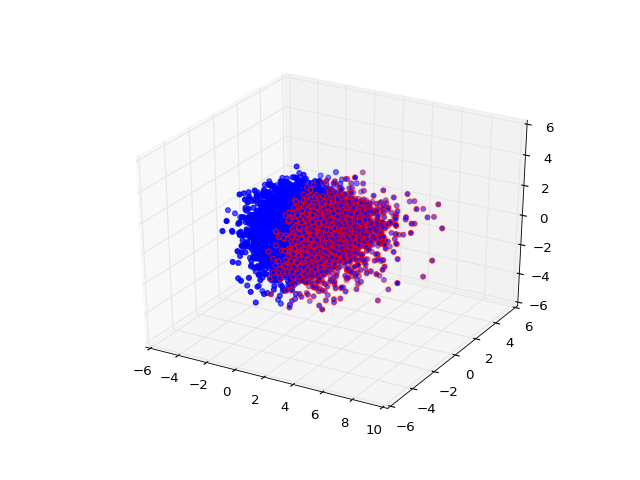

MSE: 33.418789487145034
Cluster 0 Size: 2675
MSE: 46.83630016573687
Cluster 1 Size: 5932


In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans


clusters = 2

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

km = KMeans(
    n_clusters=clusters, init='random',
    n_init=10, max_iter=2000, 
    tol=1e-04, random_state=0
)

#y_km = km.fit_predict(scaled)
y_km = km.fit_predict(standardized_new)

color_wheel = ['red', 'blue', 'green', 'orange', 'purple']
for i in range(0, clusters):
    temp = standardized_new[y_km == i]
    mean_for_cluster = km.cluster_centers_[i]
    mse = 0
    for temp_row in temp:
        abs_diff = np.abs(np.sum(mean_for_cluster - temp_row))
        mse += abs_diff
    mse /= len(temp_row)
    mse = np.sqrt(mse)
    print('MSE: %s' % mse)
    print('Cluster %s Size: %s' % (i, len(temp)))
    ax.scatter(temp[:, 0], temp[:, 1], temp[:, 2], color = color_wheel[i])
plt.show()

In [22]:
standardized = standardized_new

In [23]:
% matplotlib inline

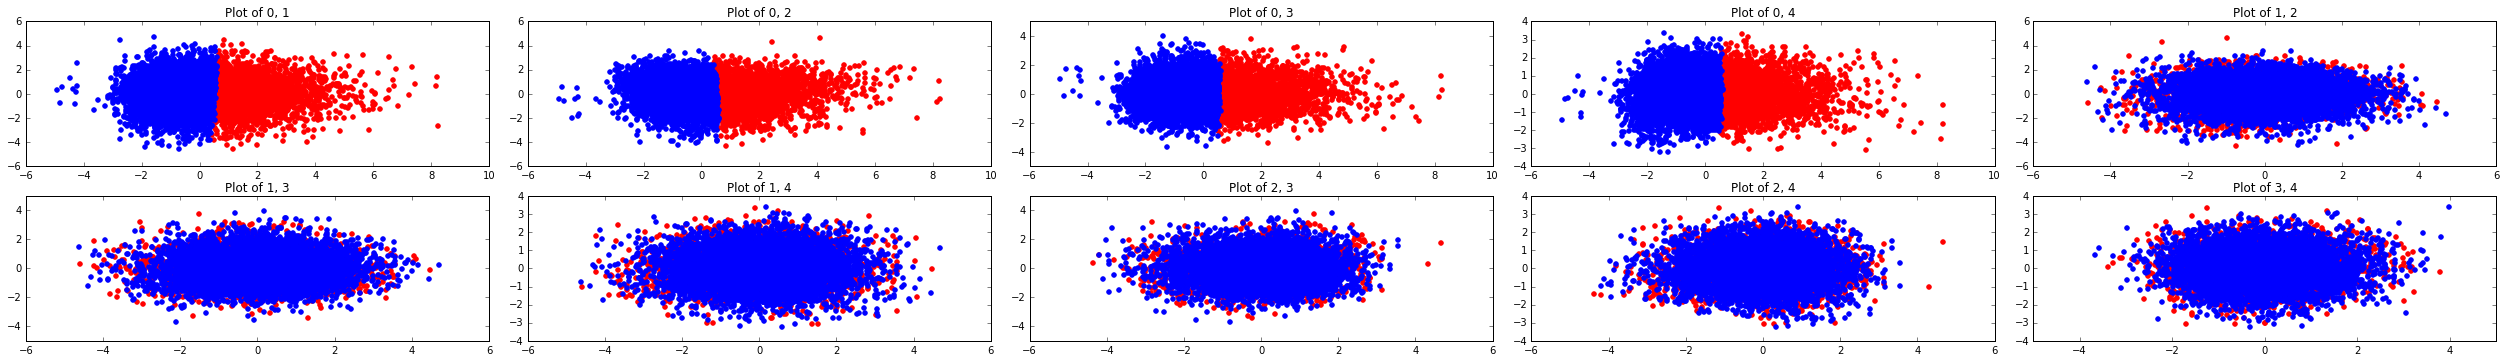

In [24]:
import itertools

combos = sorted(list(itertools.combinations([i for i in range(0, standardized.shape[1])], 2)), key = lambda x: x[0], )
dims = len(combos)

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (35, 5))
fig.tight_layout()

ix = 0
for r in range(0, dims//5):
    for c in range(0, dims//2):
        combo = combos[ix]
        for i in range(0, clusters):
            temp = standardized[y_km == i]
            ax[r][c].scatter(temp[:, combo[0]], temp[:, combo[1]], color = color_wheel[i])
        ax[r][c].title.set_text('Plot of %s, %s' % (combo))
        ix += 1

In [ ]:
teamid_dict = {'ATL': 1610612737, 'BKN': 1610612751, 'BOS': 1610612738, 'CHA': 1610612766, 'CHI': 1610612741,
               'CLE': 1610612739, 'DAL': 1610612742, 'DEN': 1610612743, 'DET': 1610612765, 'GSW': 1610612744,
               'HOU': 1610612745, 'IND': 1610612754, 'LAC': 1610612746, 'LAL': 1610612747, 'MEM': 1610612763,
               'MIA': 1610612748, 'MIL': 1610612749, 'MIN': 1610612750, 'NOP': 1610612740, 'NYK': 1610612752,
               'OKC': 1610612760, 'ORL': 1610612753, 'PHI': 1610612755, 'PHX': 1610612756, 'POR': 1610612757,
               'SAC': 1610612758, 'SAS': 1610612759, 'TOR': 1610612761, 'UTA': 1610612762, 'WAS': 1610612764,
               'NJN': 1610612751, 'SEA': 1610612760, 'NOH': 1610612740}
reversed_teamid_dict = {v:k for k, v in teamid_dict.items()}

In [ ]:
from collections import Counter

In [ ]:
def convertTeamIDToName(team_id_keyset):
    return [reversed_teamid_dict[team] for team in team_id_keyset]

def plot_freq_data(temp_data, temp_group, filter_id):
    color_wheel = ['red', 'blue', 'green', 'purple', 'orange']
    prev = None

    with open('final_data_pickles/win_loss.p', 'rb') as f:
        win_loss = pickle.load(f)

    all_labels = set()
    fig, ax = plt.subplots(figsize=(20, 5))

    counters = []
    for i in range(0, clusters):
        game_id_clusters = temp_group[filter_id == i]
        data_cluster = temp_data[filter_id == i]

        teams_in_cluster = [{v:k for k, v in win_loss[game_id].items()}['L'] for game_id in game_id_clusters]
        counterized = Counter(teams_in_cluster)
        print(counterized)
        if prev is None:
            ax.bar(counterized.keys(), counterized.values(), color = color_wheel[i])
            prev = counterized
        else:
            common = set(counterized.keys()).intersection(prev.keys())
            ax.bar(common, [counterized[temp] for temp in common], bottom = [prev[temp] for temp in common], color = color_wheel[i])
            not_in_prev = set(counterized.keys()).difference(prev.keys())
            ax.bar(not_in_prev, [counterized[temp] for temp in not_in_prev], color = color_wheel[i + 1])
        all_labels.update(set(counterized.keys()))
        counters.append(counterized)

    list_labels = list(all_labels)
    ax.set_xticks(list_labels)
    ax.set_xticklabels(convertTeamIDToName(list_labels))
    plt.title('Tank Breakdown across Teams from 2008-2020')
    plt.show()
    return counters
    
counters = plot_freq_data(final_data, groups, y_km)

In [ ]:
for team_id, red_vals in counters[0].items():
    blue_vals = counters[1][team_id]
    print('Ratio %s: %0.3f%%' % (reversed_teamid_dict[team_id] ,(blue_vals/(red_vals+blue_vals))*100))

In [ ]:
def getGameIDToYear():
    return pickle.load(open('game_map.p', 'rb'))

def caseStudy(year = 2018):
    with open('win_loss.p' , 'rb') as f:
        win_loss = pickle.load(f)
        
    game_id_to_year = getGameIDToYear()
    
    mask = [game_id_to_year[group] == year for group in groups]
    filtered_data = standardized[mask]
    filtered_groups = np.array(groups)[mask]
    filter_filter = y_km[mask]
    #plot_freq_data(filtered_data, filtered_groups, filter_filter)
    temp_group = []
    for game_id in filtered_groups:
        if game_id not in win_loss.keys():
            continue
        team1, team2 = win_loss[game_id].keys()
        loser = team1 if win_loss[game_id][team1] == 'L' else team2
        temp_group.append([game_id, loser])
    filtered_groups = np.array(temp_group)
    first = filtered_groups[filter_filter == 0]
    second = filtered_groups[filter_filter == 1]
    
    tank_cluster = None
    not_taken_cluster = None
    if first.shape[0] < second.shape[0]:
        tank_cluster = first
        not_taken_cluster = second
    else:
        tank_cluster = second
        not_taken_cluster = first
    return tank_cluster, not_taken_cluster

tanked, not_tanked = caseStudy(year = 2017)
with open('final_data_pickles//2017_tanked_data.p', 'wb') as f:
    pickle.dump({
        'tanked': tanked,
        'not_tanked': not_tanked
    }, f)

In [ ]:
print(tanked, not_tanked)

In [ ]:
%matplotlib notebook

In [ ]:
from sklearn.mixture import GMM
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

clusters = 2
gmm = GMM(n_components=clusters)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


#y_km = km.fit_predict(scaled)
y_km = gmm.fit_predict(standardized)

color_wheel = ['red', 'blue', 'green', 'orange', 'purple']
for i in range(0, clusters):
    temp = standardized[y_km == i]
    mean_for_cluster = km.cluster_centers_[i]
    mse = 0
    for temp_row in temp:
        abs_diff = np.abs(np.sum(mean_for_cluster - temp_row))
        mse += abs_diff
    mse /= len(temp_row)
    mse = np.sqrt(mse)
    print('MSE: %s' % mse)
    print('Cluster %s Size: %s' % (i, len(temp)))
    ax.scatter(temp[:, 0], temp[:, 1], temp[:, 2], color = color_wheel[i])
plt.show()


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=9)
pca.fit(standardized)
print(pca.explained_variance_ratio_)

new = pca.fit_transform(standardized)

In [ ]:
% matplotlib inline

In [ ]:
plt.plot(pca.explained_variance_ratio_)
plt.title('')
plt.show()

In [ ]:
import itertools

combos = sorted(list(itertools.combinations([i for i in range(0, standardized.shape[1])], 2)), key = lambda x: x[0], )
dims = len(combos)

fig, ax = plt.subplots(nrows = 2, ncols = 18, figsize = (35, 5))
fig.tight_layout()

ix = 0
for r in range(0, dims//18):
    for c in range(0, dims//2):
        combo = combos[ix]
        for i in range(0, clusters):
            temp = standardized[y_km == i]
            ax[r][c].scatter(temp[:, combo[0]], temp[:, combo[1]], color = color_wheel[i])
        ax[r][c].title.set_text('Plot of %s, %s' % (combo))
        ix += 1

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression


def check2017(teams = ['PHX', 'DET', 'DAL', 'LAL', '']):
    teamid_dict = {'ATL': 1610612737, 'BKN': 1610612751, 'BOS': 1610612738, 'CHA': 1610612766, 'CHI': 1610612741,
               'CLE': 1610612739, 'DAL': 1610612742, 'DEN': 1610612743, 'DET': 1610612765, 'GSW': 1610612744,
               'HOU': 1610612745, 'IND': 1610612754, 'LAC': 1610612746, 'LAL': 1610612747, 'MEM': 1610612763,
               'MIA': 1610612748, 'MIL': 1610612749, 'MIN': 1610612750, 'NOP': 1610612740, 'NYK': 1610612752,
               'OKC': 1610612760, 'ORL': 1610612753, 'PHI': 1610612755, 'PHX': 1610612756, 'POR': 1610612757,
               'SAC': 1610612758, 'SAS': 1610612759, 'TOR': 1610612761, 'UTA': 1610612762, 'WAS': 1610612764,
               'NJN': 1610612751, 'SEA': 1610612760, 'NOH': 1610612740}
    
    comparison_tests = [
        'final_data_pickles//weighted_age_bygame_reformat.p',
        'final_data_pickles//pace.p',
        'final_data_pickles//margin_of_v.p'
    ]
    fig, ax = plt.subplots(nrows = len(teams), ncols = len(comparison_tests), figsize = (25, 10))

    for r, team in enumerate(teams):
        for c, test in enumerate(comparison_tests):
            age_dict = pickle.load(open(test, 'rb'))
            numpy_data = create_numpy_array(age_dict[teamid_dict[team]][2017])
            if len(numpy_data) == 2:
                numpy_data = numpy_data[0]
            raveled = numpy_data.ravel().astype(np.float)
            age_data = pd.DataFrame(raveled)
            rolling = age_data.rolling(window=6)
            rolling_mean = rolling.mean()
            ax[r][c].plot(rolling_mean)
            
            reg = LinearRegression()
            x_data = np.arange(1, len(raveled) + 1).reshape(len(raveled), 1)
            y_data = raveled.reshape(len(raveled), 1)
            reg.fit(x_data, y_data)
            plot_line = ax[r][c].plot(reg.predict(x_data), '--', c = 'r')

            
    for axt, col in zip(ax[0], comparison_tests):
        axt.set_title(col.split('//')[1].split('.')[0])

    for axt, row in zip([ax[r][0] for r in range(len(teams))], teams):
        axt.set_ylabel(row, rotation=90, size='large')

    fig.tight_layout()
    plt.show()

check2017()

In [ ]:
def organize_data_to_tensor(data, win_loss, draft_order, num_draft_teams = -1, checkYear = None):
    """
    We basically want to organize the data to the following form:
    
    data = {
        'year': mxnxk, matrix, where m are all the games,  n are all the teams, and k are the five parameters of the data:
                
                1) Golden Lineup 2) Pythag_win_differential 3) Weighted age Differential
                
                Theoretically m should be dim 82 (games), n should be 30 (for teams), and k should be 5 (for our stats)
    }
    """
    
    with open('final_data_pickles/%s' % win_loss, 'rb') as f:
        win_loss = pickle.load(f)
    
    with open('final_data_pickles/%s' % (draft_order), 'rb') as f:
        draft_order = pickle.load(f)
        
    num_stats = len(data)
    master = {}
    for ix, stat in enumerate(data):
        with open('final_data_pickles/%s' % stat, 'rb') as f:
            stat_data = pickle.load(f)
            for team in stat_data.keys():
                for year in stat_data[team].keys():
                    if team not in draft_order[year][:num_draft_teams]:
                        continue
                    if year is not None and year != checkYear:
                        continue
                        
                    team_year_data = stat_data[team][year]
                    num_games = len(team_year_data)
                    
                    if year not in master.keys():
                        master[year] = {}
                    
                    numpy_array = create_numpy_array(team_year_data)
                    if isinstance(numpy_array, tuple):
                        game_ids = numpy_array[1]
                        numpy_array = numpy_array[0]
                    else:
                        game_ids = None
                        numpy_array = numpy_array
                        
                    if team not in master[year]:
                        master[year][team] = np.concatenate((numpy_array, game_ids, np.arange(1, len(game_ids) + 1).reshape(game_ids.shape)), axis = 1)
                    else:
                        try:
                            row_data = create_numpy_array(team_year_data)
                            if len(master[year][team]) < len(row_data):
                                master[year][team] = np.concatenate([master[year][team],
                                                                     numpy_array[0:len(master[year][team])]
                                                                    ], axis = 1)
                            else:
                                master[year][team] = np.concatenate([master[year][team], numpy_array], axis = 1)
                        except ValueError as e:
                            print('This year %s and this %s team, is causing problems: \n\n%s' % (year, team, str(e)))
                            print('Basically trying to concatenate these two arrays: ')
                            print('1)%s' % ','.join(data[0:ix]), master[year][team], master[year][team].shape)
                            print('2)%s' % (stat), numpy_array, team_year_data.shape)
                            raise Exception('Nah this aint working')
    
    for year in master.keys():
        for team in master[year].keys():
            new = []
            for game in master[year][team]:
                game_id = int(float(game[1]))
                if game_id not in win_loss.keys():
                    continue
                team1, team2 = win_loss[game_id].keys()
                loser = team1 if win_loss[game_id][team1] == 'L' else team2
                if loser == team:
                    new.append(game)
            master[year][team] = np.array(new)
                
    master_master = {}
    
    
    # adding all teams of the same year to a mxn (n number of teams)
    for year in master.keys():
        for team in master[year].keys():
            if year not in master_master.keys():
                master_master[year] = master[year][team].astype(np.float64)
            else:
                master_master[year] = np.concatenate([master_master[year], master[year][team].astype(np.float64)], axis = 0)
    compressed = None
    compressed_groups = None
    for year in master_master.keys():
        if compressed is None:
            compressed = np.delete(master_master[year], 1, axis = 1)
            compressed_groups = master_master[year][:, 1].astype(np.int64)
        else:
            compressed = np.concatenate((compressed, np.delete(master_master[year], 1, axis = 1)), axis = 0)
            compressed_groups = np.concatenate((compressed_groups, master_master[year][:, 1].astype(np.int64)), axis = 0)        
    return compressed, compressed_groups

In [ ]:
from random import shuffle
import itertools

In [ ]:
data_2015, groups_2015 = organize_data_to_tensor(data, 'win_loss.p', 'lottery_teams.p', num_draft_teams = 14, checkYear = 2015)

In [ ]:
%matplotlib inline

In [ ]:
def shardul(year = 2015):
    teamid_dict = {'ATL': 1610612737, 'BKN': 1610612751, 'BOS': 1610612738, 'CHA': 1610612766, 'CHI': 1610612741,
               'CLE': 1610612739, 'DAL': 1610612742, 'DEN': 1610612743, 'DET': 1610612765, 'GSW': 1610612744,
               'HOU': 1610612745, 'IND': 1610612754, 'LAC': 1610612746, 'LAL': 1610612747, 'MEM': 1610612763,
               'MIA': 1610612748, 'MIL': 1610612749, 'MIN': 1610612750, 'NOP': 1610612740, 'NYK': 1610612752,
               'OKC': 1610612760, 'ORL': 1610612753, 'PHI': 1610612755, 'PHX': 1610612756, 'POR': 1610612757,
               'SAC': 1610612758, 'SAS': 1610612759, 'TOR': 1610612761, 'UTA': 1610612762, 'WAS': 1610612764,
               'NJN': 1610612751, 'SEA': 1610612760, 'NOH': 1610612740}
    tanked = ['PHI', 'PHX', 'LAL']
    not_tanked = ['GSW', 'SAS', 'CLE']
    
    result = None
    result_groups = None
    
    combined = tanked + not_tanked
    shuffle(combined)

    for team in combined:
        team_id = teamid_dict[team]
        
        with open('win_loss.p' , 'rb') as f:
            win_loss = pickle.load(f)
        
        #plot_freq_data(filtered_data, filtered_groups, filter_filter)
        temp_group = []
        for game_id in groups_2015:
            if game_id not in win_loss.keys():
                continue
            team1, team2 = win_loss[game_id].keys()
            loser = team1 if win_loss[game_id][team1] == 'L' else team2
            if loser == team_id:
                temp_group.append(True)
            else:
                temp_group.append(False)
                
        team_filter = np.array(temp_group)
        team_data, team_groups = [data_2015[team_filter], groups_2015[team_filter]]
        
        if result is None:
            result = team_data
            result_groups = team_groups
        else:
            result = np.concatenate((result, team_data), axis = 0)
            result_groups = np.concatenate((result_groups, team_groups), axis = 0)
            
    result = StandardScaler().fit_transform(result)
    clusters = 2

    km = KMeans(
        n_clusters=clusters, init='random',
        n_init=10, max_iter=3000, 
        tol=1e-04, random_state=0
    )

    #y_km = km.fit_predict(scaled)
    y_km = km.fit_predict(result)

    color_wheel = ['red', 'blue', 'green', 'orange', 'purple']
    combos = sorted(list(itertools.combinations([i for i in range(0, result.shape[1])], 2)), key = lambda x: x[0], )
    dims = len(combos)

    fig, ax = plt.subplots(nrows = 2, ncols = 18, figsize = (35, 5))
    fig.tight_layout()

    ix = 0
    for r in range(0, dims//18):
        for c in range(0, dims//2):
            combo = combos[ix]
            for i in range(0, clusters):
                temp = result[y_km == i]
                ax[r][c].scatter(temp[:, combo[0]], temp[:, combo[1]], color = color_wheel[i])
            ax[r][c].title.set_text('Plot of %s, %s' % (combo))
            ix += 1
            
    plt.show()
    
shardul()

In [ ]:
import pandas as pd


def plotWorstTeams():
    teamid_dict = {'ATL': 1610612737, 'BKN': 1610612751, 'BOS': 1610612738, 'CHA': 1610612766, 'CHI': 1610612741,
               'CLE': 1610612739, 'DAL': 1610612742, 'DEN': 1610612743, 'DET': 1610612765, 'GSW': 1610612744,
               'HOU': 1610612745, 'IND': 1610612754, 'LAC': 1610612746, 'LAL': 1610612747, 'MEM': 1610612763,
               'MIA': 1610612748, 'MIL': 1610612749, 'MIN': 1610612750, 'NOP': 1610612740, 'NYK': 1610612752,
               'OKC': 1610612760, 'ORL': 1610612753, 'PHI': 1610612755, 'PHX': 1610612756, 'POR': 1610612757,
               'SAC': 1610612758, 'SAS': 1610612759, 'TOR': 1610612761, 'UTA': 1610612762, 'WAS': 1610612764,
               'NJN': 1610612751, 'SEA': 1610612760, 'NOH': 1610612740}
    
    with open('final_data_pickles//lottery_teams.p', 'rb') as f:
        team_data = pickle.load(f)
    fig, ax = plt.subplots(figsize = (20,8))
    year_range = [i for i in range(2016, 2020)]
    for year in team_data.keys():
        if year not in year_range:
            continue
        top_four = team_data[year][0:4]
        for team in top_four:
            age_dict = pickle.load(open('final_data_pickles//weighted_age_bygame_reformat.p', 'rb'))
            numpy_data = create_numpy_array(age_dict[team][year])
            if len(numpy_data) == 2:
                numpy_data = numpy_data[0]
            raveled = numpy_data.ravel().astype(np.float)
            age_data = pd.DataFrame(raveled)
            rolling = age_data.rolling(window=6)
            rolling_mean = rolling.mean()
            plt.plot(rolling_mean)
    plt.title('Age Differential Across the Course of a Season for Top 4 Lottery Teams (2016-2020)')
    fig.tight_layout()
    plt.show()

plotWorstTeams()